In [27]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import imgLoader as ld
from drawMap import drawMapGrid
from longiLatiToImageUV import longiLatiToImageUV
import json

%load_ext autoreload
%autoreload 2

# OUTPUT_IMG_SIZE = [2048, 1024]
OUTPUT_IMG_SIZE = [16384, 8192]
# OUTPUT_IMG_SIZE = [512, 256]

PLANET_RADIUS = 260
PLANET_POSITION = [
    -18987611.119,
    -2709009.661,
    0.0
]

FOV_SCALE = 1.47
DROP_EDGE_ANGLE = 20

PATH = "./images_data/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
with open(PATH+'data.json', 'r') as f:
    database = json.load(f)

In [29]:
FILE_BG = "cellin_hd.webp"
FILES_SAMPLING = ["6.png", "7.png", "8.png"]

In [30]:
def loadBackground(file_name):
    # Load the image
    img = cv.imread(PATH+file_name, cv.IMREAD_UNCHANGED)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # Resized image to fit the output size
    img = cv.resize(img, (OUTPUT_IMG_SIZE[0], OUTPUT_IMG_SIZE[1]), interpolation=cv.INTER_AREA)

    # Check if image loaded
    if img is None:
        raise FileNotFoundError("Image not found at "+PATH+file_name)

    # Get image dimensions
    h, w = img.shape[:2]
    mid = w // 2

    # Swap left and right halves
    left = img[:, :mid]
    right = img[:, mid:]
    bg = np.hstack((right, left))
    return bg

In [31]:
def loadImageData(file_name, database):
    img = cv.imread(PATH+file_name, cv.IMREAD_UNCHANGED)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    file_data = next((item for item in database if item.get('file_name') == file_name), None)
    data = file_data.get('data')
    return img, data

In [32]:
def local_pos_to_long_lat(pos_local):
    """
    Convert local position to longitude and latitude.
    pos_local: [x, y, z] in local coordinates
    """
    x, y, z = pos_local
    r = np.sqrt(x**2 + y**2 + z**2)
    longitude = np.degrees(np.arctan2(y, x))
    latitude = np.degrees(np.arcsin(z / r)) if r != 0 else 0
    return longitude, latitude, r



In [33]:
def get_sphere_z_rotation_in_deg(pos_local, pos_world_relative):
    """
    Compute the rotation around the Z axis based on local and world-relative positions.
    pos_local: [x, y, z] in local coordinates
    pos_world_relative: [x, y, z] in world-relative coordinates
    """
    # Project both vectors onto XY plane
    local_xy = pos_local[:2]
    world_xy = pos_world_relative[:2]

    # Normalize
    local_xy_norm = local_xy / np.linalg.norm(local_xy)
    world_xy_norm = world_xy / np.linalg.norm(world_xy)

    # Compute angle (in radians)
    dot = np.clip(np.dot(local_xy_norm, world_xy_norm), -1.0, 1.0)
    angle = np.arccos(dot)

    # Determine sign using cross product (z component)
    cross = np.cross(np.append(local_xy_norm, 0), np.append(world_xy_norm, 0))
    if cross[2] < 0:
        angle = -angle

    return np.degrees(angle)

In [34]:
# Compute camera_eular_xyz_local based on planet_z_rotation and camera_eular_xyz_world
# Only the yaw (rotation around Z) is affected by planet_z_rotation
# Assuming camera_eular_xyz_world = [roll, pitch, yaw] in degrees

def rotate_euler_z(euler, z_rot_deg):
    roll, pitch, yaw = euler
    # Subtract planet_z_rotation from yaw to get local yaw
    yaw_local = yaw - z_rot_deg
    return np.array([roll, pitch, yaw_local])

In [35]:
# Compute rotated camera basis vectors in local/world frame using camera_eular_xyz_local
def euler_to_rotmat(euler):
    roll, pitch, yaw = np.radians(euler)
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])
    Ry = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    Rz = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])
    return Rz @ Ry @ Rx

In [36]:
def get_projected_camera_looking_lon_lat(camera_pos_local, rotated_forward):
    # The camera is at camera_pos_local, so the ray is: o + t*d, o = camera_pos_local, d = camera_forward_world
    # Find intersection with sphere

    o = camera_pos_local
    d = rotated_forward / np.linalg.norm(rotated_forward)
    a = np.dot(d, d)
    b = 2 * np.dot(o, d)
    c = np.dot(o, o) - PLANET_RADIUS**2
    disc = b**2 - 4*a*c
    if disc >= 0:
        t1 = (-b - np.sqrt(disc)) / (2*a)
        t2 = (-b + np.sqrt(disc)) / (2*a)
        t = t1 if t1 > 0 else t2 if t2 > 0 else None
        if t is not None and t > 0:
            p = o + t * d
            cam_look_lon, cam_look_lat, r = local_pos_to_long_lat(p)
            return cam_look_lon, cam_look_lat
        else:
            # Camera looking vector does not intersect the sphere in front of the camera.
            return None, None
    else:
        # Camera looking vector does not intersect the sphere.
        return None, None

In [37]:
def do_mapping(file_name, database):
    img, data = loadImageData(file_name, database)
    # plt.imshow(img)
    # plt.axis('off')
    # plt.show()
    
    print("Planet Center [World]", PLANET_POSITION)
    camera_pos_world_absolute = np.array(data.get('PosWorld'))
    print("Camera Position [World]", camera_pos_world_absolute)
    camera_pos_local = np.array(data.get('PosLocal'))
    print("Camera Position [Local]", camera_pos_local)
    camera_pos_world_relative = np.array(data.get('PosWorld')) - np.array(PLANET_POSITION)
    print("Camera Relative Position [World]", camera_pos_world_relative)
        
    planet_z_rotation = get_sphere_z_rotation_in_deg(camera_pos_local, camera_pos_world_relative)
    print("Planet Z Rotation (degrees):", planet_z_rotation)
    
    camera_eular_xyz_world = np.array(data.get('CamDir'))
    camera_eular_xyz_local = rotate_euler_z(camera_eular_xyz_world, planet_z_rotation)
    print("Camera Euler XYZ [World]:", camera_eular_xyz_world)
    print("Camera Euler XYZ [Local]:", camera_eular_xyz_local)
    
    # Coordinate System: X is right, Y is forward, Z is up
    # Eular angles rotation order: X -> Y -> Z
    initial_camera_forward_vec = [0, 1, 0]
    initial_camera_upward_vec = [0, 0, 1]
    initial_camera_right_vec = [1, 0, 0]
    R_local = euler_to_rotmat(camera_eular_xyz_local)

    rotated_forward = R_local @ np.array(initial_camera_forward_vec)
    rotated_upward = R_local @ np.array(initial_camera_upward_vec)
    rotated_right = R_local @ np.array(initial_camera_right_vec)

    print("Rotated Forward Vector:", rotated_forward)
    print("Rotated Upward Vector:", rotated_upward)
    print("Rotated Right Vector:", rotated_right)
    
    pos_local = data.get('PosLocal')
    cam_pos_lon, cam_pos_lat, cam_pos_r = local_pos_to_long_lat(pos_local)
    print(f"PosLocal: {pos_local} => Longitude: {cam_pos_lon:.6f}, Latitude: {cam_pos_lat:.6f}")
    cam_look_lon, cam_look_lat = get_projected_camera_looking_lon_lat(camera_pos_local, rotated_forward)
    
    camera_fov_x = data.get('FOV')*FOV_SCALE
    
    img_width = img.shape[1]
    img_height = img.shape[0]
    
    mapped = np.zeros((OUTPUT_IMG_SIZE[1], OUTPUT_IMG_SIZE[0], 4), dtype=np.uint8)
    
    for v in range(OUTPUT_IMG_SIZE[1]):
        for u in range(OUTPUT_IMG_SIZE[0]):
            la = -v / OUTPUT_IMG_SIZE[1] * 180 + 90
            lo = u / OUTPUT_IMG_SIZE[0] * 360 - 180
            uInput, vInput = longiLatiToImageUV(PLANET_RADIUS, lo, la, img_width, img_height, camera_fov_x, camera_pos_local, rotated_forward, rotated_upward, DROP_EDGE_ANGLE)
            if uInput is None or not (0 <= uInput < img_width and 0 <= vInput < img_height): 
                # mapped[v, u] = [0, 0, 0]
                continue
            color = img[vInput, uInput]
            if color.shape[0] == 3:
                alpha = 255
                mapped[v, u] = np.append(color, alpha)
            else:
                mapped[v, u] = color
            
    return mapped, [cam_pos_lon, cam_pos_lat], [cam_look_lon, cam_look_lat]

In [38]:
result = []
for idx in range(len(FILES_SAMPLING)):
    print(f"Processing file: {FILES_SAMPLING[idx]}")
    bg = loadBackground(FILE_BG)
    mapped, cam_pos, cam_look = do_mapping(FILES_SAMPLING[idx], database)
    result.append({
        'file_name': FILES_SAMPLING[idx],
        'mapped': mapped,
        'cam_pos': cam_pos,
        'cam_look': cam_look
    })

Processing file: 6.png
Planet Center [World] [-18987611.119, -2709009.661, 0.0]
Camera Position [World] [-1.89873730e+07 -2.70908778e+06  8.57125000e+01]
Camera Position [Local] [-210.3178  136.3386   85.7125]
Camera Relative Position [World] [238.158  -78.1178  85.7125]
Planet Z Rotation (degrees): -165.20657886623903
Camera Euler XYZ [World]: [-19  -1  72]
Camera Euler XYZ [Local]: [-19.          -1.         237.20657887]
Rotated Forward Vector: [ 0.79175273 -0.51688032 -0.32551857]
Rotated Upward Vector: [ 0.28261941 -0.16245982  0.94537457]
Rotated Right Vector: [-0.5415292  -0.84050077  0.01745241]
PosLocal: [-210.3178, 136.3386, 85.7125] => Longitude: 147.046659, Latitude: 18.879189
Processing file: 7.png
Planet Center [World] [-18987611.119, -2709009.661, 0.0]
Camera Position [World] [-1.89873185e+07 -2.70909369e+06  1.06152000e+02]
Camera Position [Local] [-255.6635  165.3676  106.152 ]
Camera Relative Position [World] [292.6601 -84.025  106.152 ]
Planet Z Rotation (degrees): -

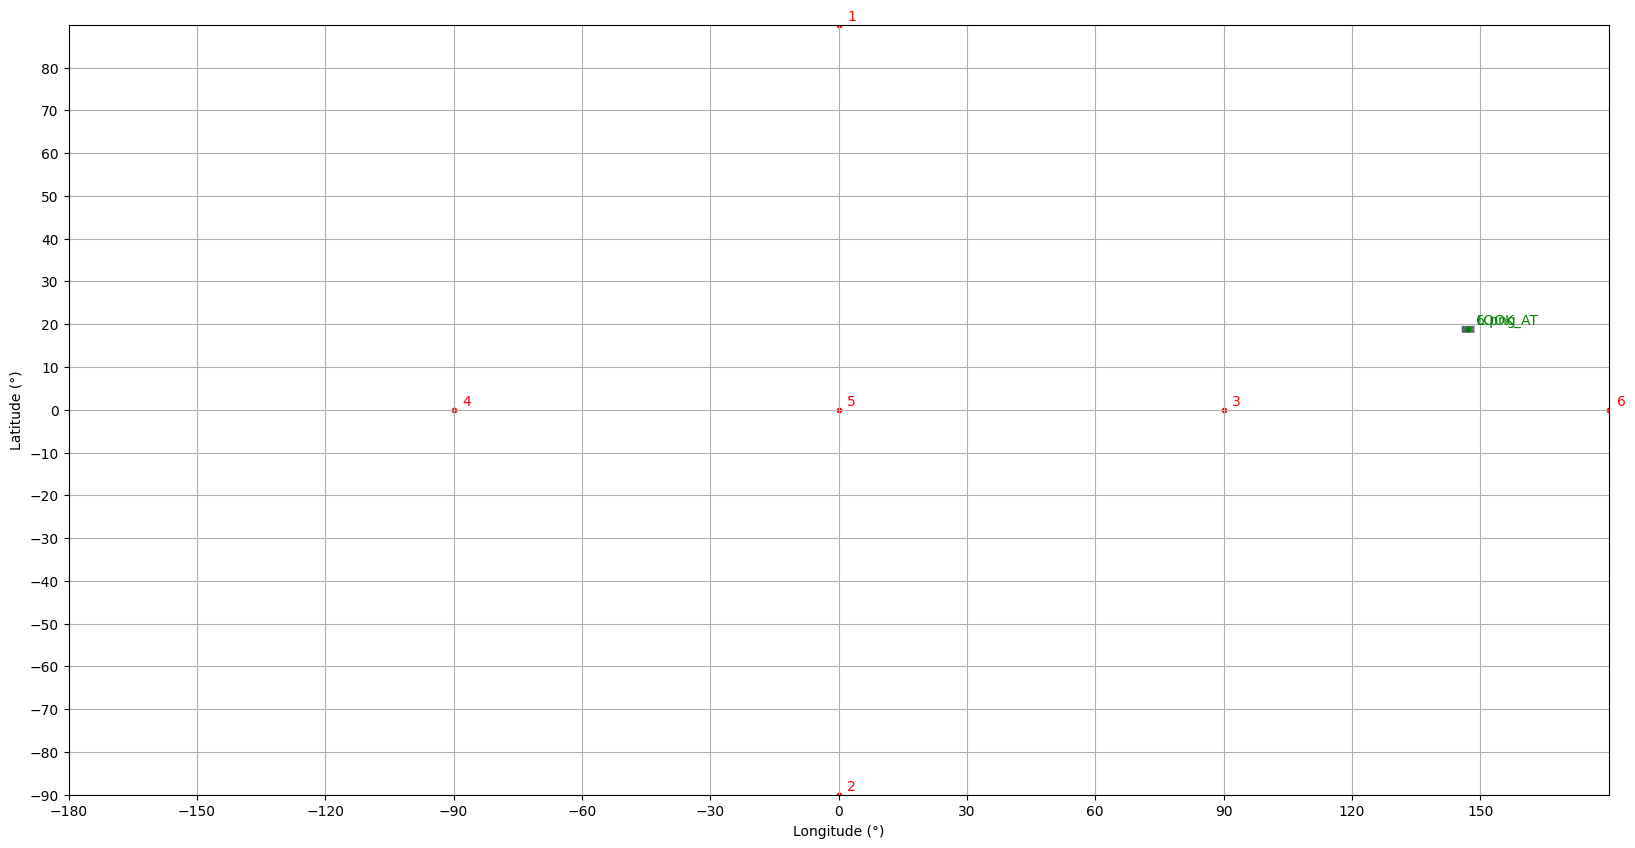

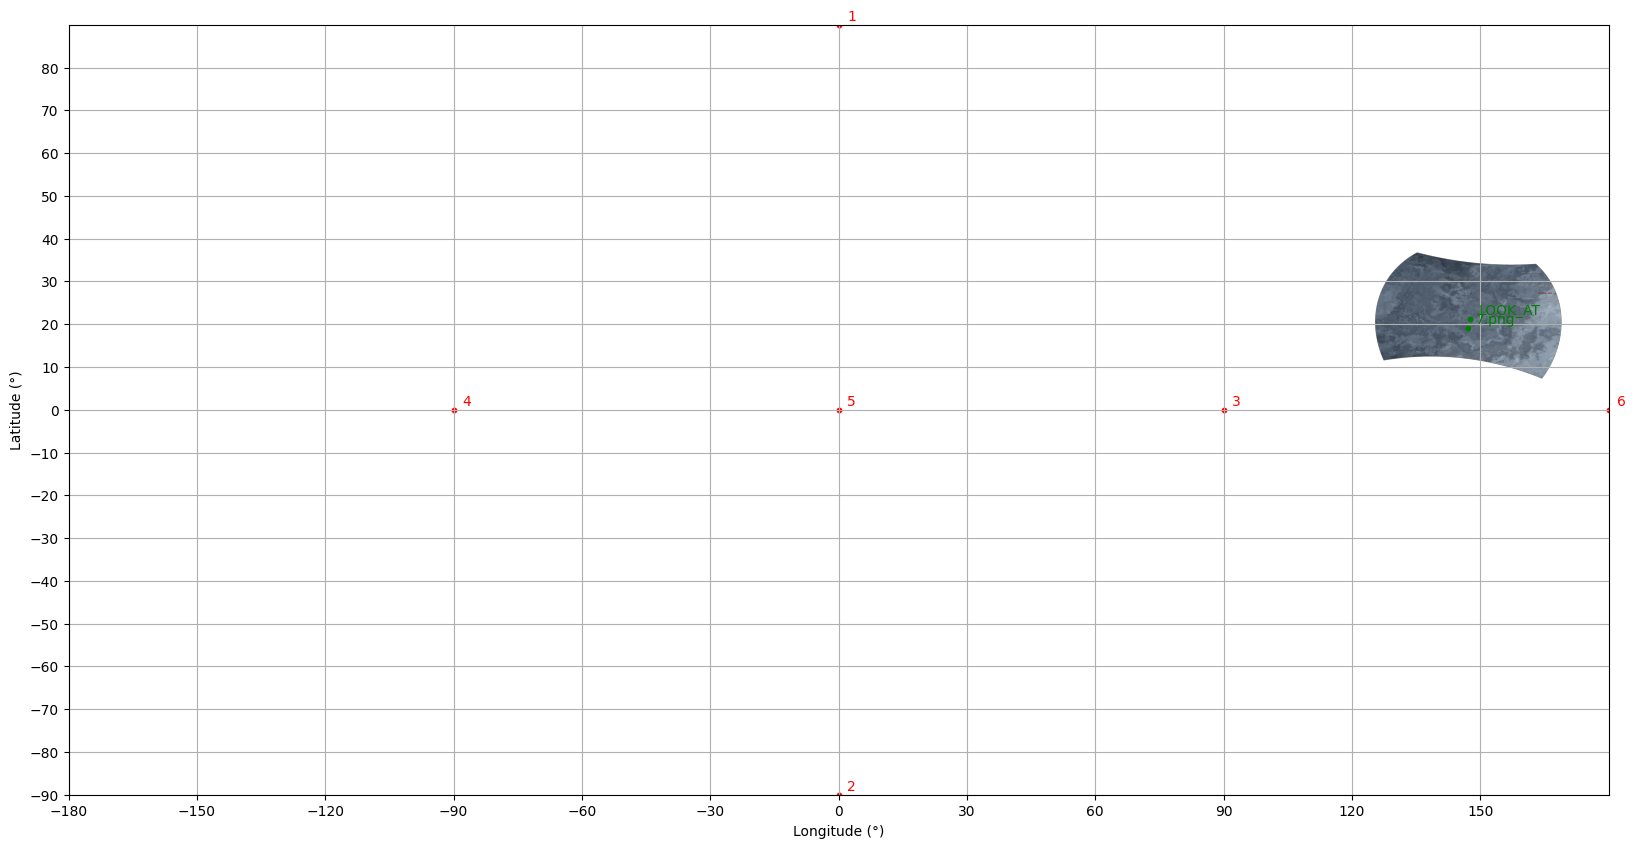

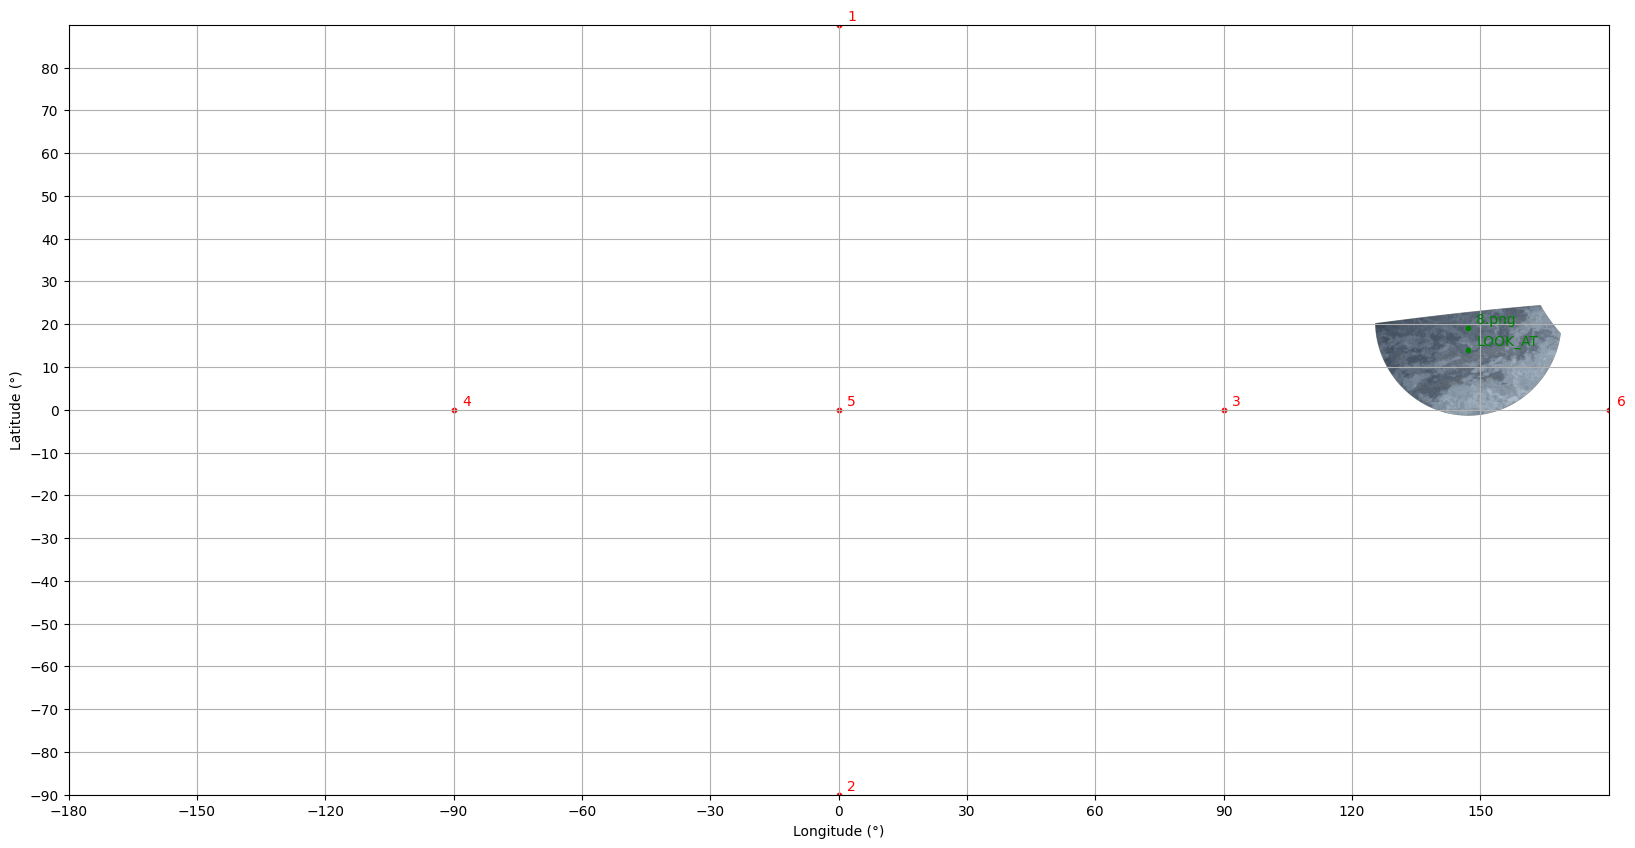

In [39]:
# Show the mapped image
for idx in range(len(result)):
    file_name = result[idx]['file_name']
    mapped = result[idx]['mapped']
    cam_pos = result[idx]['cam_pos']
    cam_look = result[idx]['cam_look']
    drawMapGrid(mapped, [cam_pos, cam_look], [file_name, "LOOK_AT"])

In [40]:

import os
def save_mapped_images(result):
    os.makedirs('./output', exist_ok=True)
    for idx in range(len(result)):
        file_name = result[idx]['file_name']
        mapped = result[idx]['mapped']
        output_file = f"./output/{file_name}"
        # Ensure mapped is uint8 and has 3 or 4 channels
        if mapped.dtype != np.uint8:
            mapped = mapped.astype(np.uint8)
        if mapped.shape[2] == 4:
            mapped_bgr = cv.cvtColor(mapped, cv.COLOR_RGBA2BGRA)
        elif mapped.shape[2] == 3:
            mapped_bgr = cv.cvtColor(mapped, cv.COLOR_RGB2BGR)
        else:
            mapped_bgr = mapped
        cv.imwrite(output_file, mapped_bgr)
        print(f"Saved mapped image to {output_file}")

save_mapped_images(result)

Saved mapped image to ./output/6.png
Saved mapped image to ./output/7.png
Saved mapped image to ./output/8.png
